### Imports

In [1]:
#libraries for plotting in an external window
# pip install PyQt5
# pip install PyQt6
# pip install PySide6
# pip install PySide2

# The usual suspects
import pandas as pd
import random
import math
import torch
# Make sure torch.__version__>1.10

# Homemade librairies
from volume_interest import *
from tracking import *
from plots import *

# Classes tutorial

We create several classes to make the implementation of the algorithm easier. In this tutorial we will go through 3 of them:

- `volume_interest.py`
- `plots.py`
- `tracking.py`

## 1 - volume_interest.py

The **EM algorithm** implementation relies on a **voxelized volume of interest (VOI)**. As its name indicates, the `VolumeOfInterest` class is responsible for the modeling of the volume of interest and its voxelization. 

### Instanciation

When declaring an **instance** of `VolumeOfInterest`, one must provide **3 parameters**:

- `low_high_edges`: `([x_low,y_low,z_low], [x_high,y_high,z_high])` in m, representing repectivly the **bottom** and **upper** corner **of the VOI**.


- `n_vox_xyz`: `Tuple[int] = [Nx,Ny,Nz]` respectively the **number of voxels** along the x,y and z direction.


- `voxel_width`: `float` the **size of a voxel** in m. **Make sure that `(i_high - i_low)/voxel_width = Ni` !!**

If these parameters are not provided, default parameters corresponding to standard TomOpt VOI will be used. In case one wants a custom VOI, the `VolumeOfInterest` should be instancieted as follow:

In [2]:
# Default VOI instanciation
voi = VolumeOfInterest()

# Custom VOI instanciation
xyz_min = [0, 0, 0.2] # in meters
xyz_max = [1, 1, 0.8] # in meters
n_vox_xyz = (10,10,6) 
voxel_width = 0.1 # in meters

voi = VolumeOfInterest(low_high_edges = (xyz_min,xyz_max), 
                       n_vox_xyz = n_vox_xyz,
                       voxel_width = voxel_width)

### Features

The `generate_voxels()` method will **generate a grid of voxels** based on the input parameters provided above, using the `compute_voxel_centers`. Features of the voxelized volume are:

 - `voxel_centers`: `torch.tensor()` with size `(Nx,Ny,Nz,3)`. It contains the $x,y,z$ position of the center of each voxel. The position of the center of the voxel with indices $ix,iy,iz$ is `voxel_centers[ix,iy,iz]`.
 
 
 
 - `voxel_edges`: `torch.tensor()` with size `(Nx,Ny,Nz,2,3)`. It contains the $x,y,z$ position of the lower left and upper righ corner of each voxel. The positions of the lower left and upper right corner of the voxel with indices $ix,iy,iz$ are respectively `voxel_centers[ix,iy,iz,0,:]` and `voxel_centers[ix,iy,iz,1,:]`. 
 
 

In [3]:
ix,iy,iz = 0,0,0

# Voxel centers
print('Voxel with indices {},{},{} is located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_centers[ix,iy,iz].numpy()))

# Voxel edges
print('\nLower left corner of voxel with indices {},{},{} \nis located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_edges[ix,iy,iz,0].numpy()))
print('\nUpper right corner of voxel with indices {},{},{} \nis located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_edges[ix,iy,iz,1].numpy()))

Voxel with indices 0,0,0 is located at x,y,z = [0.05 0.05 0.75]

Lower left corner of voxel with indices 0,0,0 
is located at x,y,z = [0.  0.  0.7]

Upper right corner of voxel with indices 0,0,0 
is located at x,y,z = [0.1 0.1 0.8]


Now that the VOI is properly defined, we can have a look at it using the `plot_muon_track()` method (in `plot.py`). This method is designed to plot both the VOI and a given track but if `track` is none it only plots the VOI.

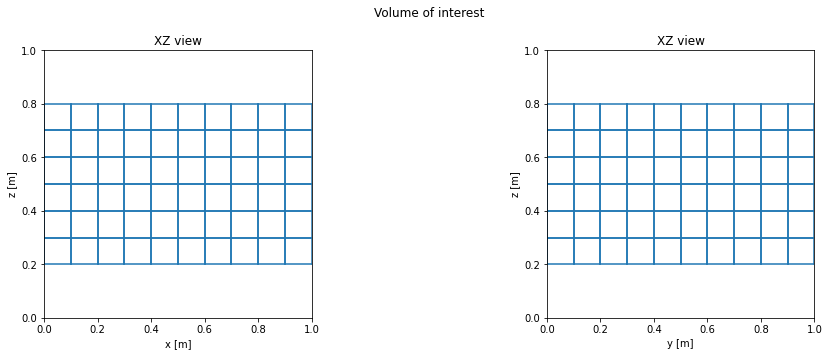

In [4]:
plot_muon_track(VOI=voi)

## 2 - tracking.py 

The EM algorithm will require the position of a muon every time it enters and exits a voxel. The **`Tracking` class** will handle all the **computations** related to the **tracks** and the **voxel triggering**.

### Instanciation

 - `voi`: An instance of the `VolumeOfInterest` class.
 
 - `data`: `pandas.DataFrame`
 
The dataset we use contains the following features: 

In [5]:
data = pd.read_csv('10000muons_10000resolution_z5z6lead_5_5_POCA_1.csv')
print('Features:')
print(data.columns)

myTracks=Tracking(voi,data)

Features:
Index(['Unnamed: 0', 'theta_xy_in_x', 'theta_xy_in_y', 'theta_xy_in_unc_x',
       'theta_xy_in_unc_y', 'theta_xy_out_x', 'theta_xy_out_y',
       'theta_xy_out_unc_x', 'theta_xy_out_unc_y', 'xyz_in_x', 'xyz_in_y',
       'xyz_in_z', 'xyz_in_unc_x', 'xyz_in_unc_y', 'xyz_in_unc_z', 'xyz_out_x',
       'xyz_out_y', 'xyz_out_z', 'xyz_out_unc_x', 'xyz_out_unc_y',
       'xyz_out_unc_z', 'mom', 'location_x', 'location_y', 'location_z'],
      dtype='object')

Voxel triggering: in pogress



Voxel triggering: DONE


### Features

For now, only 2 features are computed:

- `tracks`: `torch.tensor` with size `[3,VOI.n_vox_xyz[2]+1,Nevent]`. It contains the muon position ($x,y,z$) when entering/exiting a layer of voxel along z. Computed by the `compute_discrete_tracks()` method.



- `triggered_voxels`: `list` with length `Nevent`. Each element of the list is a `torch.tensor` with size `[N,3]` where `N` is the number of triggered voxels of the given event.

In [6]:
# tracks
layer = 0
event = 0
print('\nMuon #{} enters voxel layer {} at x,y,z = {},{},{}'.format(event,
                                                                 layer,
                                                                 myTracks.tracks[0,layer,event].numpy(),
                                                                 myTracks.tracks[1,layer,event].numpy(),
                                                                 myTracks.tracks[2,layer,event].numpy()))
print('\nMuon #{} exits voxel layer {} at x,y,z = {},{},{}'.format(event,
                                                                 layer,
                                                                 myTracks.tracks[0,layer+1,event].numpy(),
                                                                 myTracks.tracks[1,layer+1,event].numpy(),
                                                                 myTracks.tracks[2,layer+1,event].numpy()))

# triggered_voxels
print('\nMuon #{} triggers voxels with indices:\n {}'.format(event, myTracks.triggered_voxels[event].numpy()))


Muon #0 enters voxel layer 0 at x,y,z = 0.9046624981099218,0.9242213047844551,0.800000011920929

Muon #0 exits voxel layer 0 at x,y,z = 0.9173465996667721,0.8921133675101842,0.699999988079071

Muon #0 triggers voxels with indices:
 [[9. 7. 2.]
 [9. 7. 3.]
 [9. 7. 4.]
 [9. 7. 5.]
 [9. 8. 0.]
 [9. 8. 1.]
 [9. 8. 2.]
 [9. 8. 3.]
 [9. 8. 4.]
 [9. 9. 0.]
 [9. 9. 1.]]


We can know plot above's features using the `plot_muon_track()`, `plot_discrete_track_2d()` and `plot_discrete_track_3d()` functions from plot.py.

The plots.py file contains functions for visualizing the muon trajectory and triggered voxels inside the volume of interest (VOI) in 2- and 3-dimensional orientations.

### Functions

 - `plot_muon_track`: Plots only the muon trjectory within the VOI.
 
 - `plot_discrete_track_2d`: 2D visualization of muon trajectories and triggered voxels within the VOI.
 
 - `plot_discrete_track_3d`: 3D visualization of muon trajectories and triggered voxels within the VOI.
 
These functions have the same following input parameters:

- `VOI`: instance of the VolumeOfInterest class

- `tracking`: instance of the Tracking class

- `event`: event number


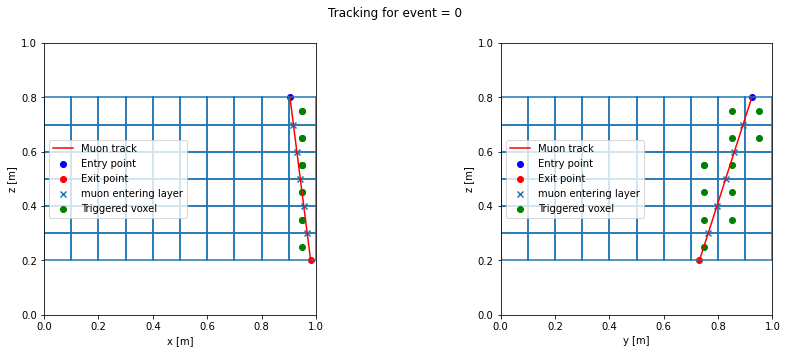

In [7]:
plot_discrete_track_2d(VOI=voi, tracking=myTracks, event = event)

In [9]:
#viewing plot in an external window and rotating the VOI
%matplotlib qt 
plot_discrete_track_3d(VOI=voi, tracking=myTracks)

ERROR:tornado.application:Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x7ffa21214790>)
Traceback (most recent call last):
  File "/home/geant/miniforge3/lib/python3.9/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/geant/miniforge3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 402, in advance_eventloop
    eventloop(self)
  File "/home/geant/miniforge3/lib/python3.9/site-packages/ipykernel/eventloops.py", line 128, in loop_qt5
    return loop_qt4(kernel)
  File "/home/geant/miniforge3/lib/python3.9/site-packages/ipykernel/eventloops.py", line 119, in loop_qt4
    _notify_stream_qt(kernel, kernel.shell_stream)
  File "/home/geant/miniforge3/lib/python3.9/site-packages/ipykernel/eventloops.py", line 40, in _notify_stream_qt
    notifier = QtCore.QSocketNotifier(fd, QtCore.QSocketNotifier.Read, kernel.app)
AttributeError: type object 'QSocketNotifier' has no attribute 'R